# Speech Command Recognition using Convolutional Neural Networks and GRU 

______________________________
## Overview 
This project focuses on building a speech command recognition system using a combination of Convolutional Neural 
Networks (CNN) and Cated Recurrent units (GRIJ). The system is designed to classify spoken commands trom audio 
recordings. The proJect involves data extraction, preprocessing, model training, and evaluation using TensorFlow and Keras. 
## Key Features: 
- **Data Extraction:** Extracts audio data trom a compressed file and organizes it into training, validation, and test sets. 
- **Data Augmentation:** Adds background noise to audio samples to improve model robustness. 
- **Spectrogram Conversion:** Converts audio wavetorms into spectrograms for better teature extraction. 
- **Model Architecture:** Combines CNN layers for spatial teature extraction and GRU layers for temporal teature 
learning. 
- **Training and Validation:** Trains the model With early stoppingto prevent overtittingand evaluates its performance on 
validation data. 
- **Performance Evaluation:** Tests the model on unseen data and visualizes the results using confusion matrices and 
accuracy metrics. 
- **Submission Preparation:** Prepares and saves predictions for a Kaggle competition submission.

In [2]:
!pip install py7zr -q

In [3]:
import os
import py7zr
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from IPython import display

In [15]:
# Data and extraction directories
data_dir = "/kaggle/input/tensorflow-speech-recognition-challenge/"
extract_dir = '/kaggle/working/extracted_data_train'

def extract_7z(filepath, dest_dir):
    with py7zr.SevenZipFile(filepath, mode='r') as z:
        z.extractall(path=dest_dir)

# Extract the data if it hasn't been already
if not os.path.exists(extract_dir):
    filepath = os.path.join(data_dir, "train.7z")
    print(f"Extracting files from {filepath} to {extract_dir}...")
    extract_7z(filepath, extract_dir)
else:
    print(f"Data already extracted at {extract_dir}")

Extracting files from /kaggle/input/tensorflow-speech-recognition-challenge/train.7z to /kaggle/working/extracted_data...


In [16]:
# Load command labels
commands = np.array([d for d in tf.io.gfile.listdir(os.path.join(extract_dir, "train/audio")) 
                    if d != '_background_noise_'])
print('Commands:', commands)

# Load background noise files for data augmentation
noise_dir = os.path.join(extract_dir, "train/audio/_background_noise_")
noise_files = tf.io.gfile.glob(noise_dir + '/*.wav')

# Function to decode audio files
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    return tf.squeeze(audio, axis=-1)

# Function to extract label from file path
def get_label(file_path):
    label = tf.strings.split(input=file_path, sep=os.path.sep)[-2]
    return tf.cond(tf.reduce_any(tf.equal(commands, label)), lambda: label, lambda: tf.constant("unknown", dtype=tf.string))

# Function to convert waveform to spectrogram
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    # Pad with zeros if audio is shorter than 16000 samples
    zero_padding = tf.zeros([input_len] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram[..., tf.newaxis]

# Function to add background noise for data augmentation
def add_background_noise(waveform, noise_files):
    noise_file = random.choice(noise_files)
    noise_audio_binary = tf.io.read_file(noise_file)
    noise_waveform = decode_audio(noise_audio_binary)

    # Adjust noise length to match the audio
    waveform_len = tf.shape(waveform)[0]
    noise_len = tf.shape(noise_waveform)[0]
    if noise_len > waveform_len:
        offset = tf.random.uniform(shape=[], minval=0, maxval=noise_len - waveform_len, dtype=tf.int32)
        noise_waveform = noise_waveform[offset:offset + waveform_len]
    else:
        padding = tf.zeros([waveform_len - noise_len], dtype=tf.float32)
        noise_waveform = tf.concat([noise_waveform, padding], axis=0)

    noise_factor = tf.random.uniform(shape=[], minval=0.0, maxval=0.5)
    augmented_waveform = waveform + noise_factor * noise_waveform
    return tf.clip_by_value(augmented_waveform, -1.0, 1.0)

# Function to load and preprocess audio data
def preprocess_dataset(files, augment=False):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
        lambda file_path: (tf.io.read_file(file_path), get_label(file_path)), 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    output_ds = output_ds.map(
        lambda audio_binary, label: (decode_audio(audio_binary), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    if augment:
        output_ds = output_ds.map(
            lambda waveform, label: (add_background_noise(waveform, noise_files), label), 
            num_parallel_calls=tf.data.AUTOTUNE
        )
    output_ds = output_ds.map(
        lambda waveform, label: (get_spectrogram(waveform), tf.argmax(label == commands)),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return output_ds

Commands: ['seven' 'bed' 'cat' 'up' 'happy' 'bird' 'marvin' 'left' 'down' 'zero'
 'house' 'two' 'right' 'five' 'nine' 'four' 'eight' 'yes' 'stop' 'one'
 'go' 'dog' 'tree' 'on' 'three' 'sheila' 'six' 'no' 'wow' 'off']


In [17]:
filepath_data = os.path.join(extract_dir, "train/audio")

# Get all filenames, excluding noise files
filenames = tf.io.gfile.glob([os.path.join(filepath_data, d,  '*') for d in commands])
filenames = tf.random.shuffle(filenames)

total_samples = len(filenames)
train_size = int(0.8 * total_samples)  # 80% for training
val_size = int(0.1 * total_samples)  # 10% for validation
test_size = total_samples - train_size - val_size  # Remaining 10% for testing

# Split dataset into train, validation, and test sets
train_files = filenames[:train_size]
val_files = filenames[train_size:train_size + val_size]
test_files = filenames[train_size + val_size:]

print('Training set size:', len(train_files))
print('Validation set size:', len(val_files))
print('Test set size:', len(test_files))

Training set size: 51776
Validation set size: 6472
Test set size: 6473


In [18]:
train_ds = preprocess_dataset(train_files, augment=True)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

# Batch the datasets for training
batch_size = 32
train_ds = train_ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [31]:
# Get input shape from the data
for spectrogram, _ in train_ds.take(1):
    input_shape = spectrogram.shape[1:]

print('Input shape:', input_shape)
num_labels = len(commands)

# Normalize input
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_ds.map(lambda spec, label: spec))

timesteps = 16

# Build the model
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Reshape((-1, timesteps, 21632 // timesteps)), 
    tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=1)),
    layers.GRU(64),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Input shape: (124, 129, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 16, 1352)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 16, 1352)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │       272,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 377,121 (1.44 MB)

 Trainable params: 377,118 (1.44 MB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/20
   1/1618 ━━━━━━━━━━━━━━━━━━━━ 55:28 2s/step - accuracy: 0.0312 - loss: 3.4067

2024-10-10 17:46:27.893147: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_2_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1618/1618 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.0782 - loss: 3.2007 - val_accuracy: 0.3609 - val_loss: 2.0278
Epoch 2/20
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.2748 - loss: 2.3999 - val_accuracy: 0.5481 - val_loss: 1.4444
Epoch 3/20
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.3705 - loss: 2.0948 - val_accuracy: 0.6422 - val_loss: 1.1566
Epoch 4/20
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.4226 - loss: 1.9144 - val_accuracy: 0.7001 - val_loss: 0.9793
Epoch 5/20
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.4597 - loss: 1.7988 - val_accuracy: 0.7131 - val_loss: 0.9384
Epoch 6/20
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.4862 - loss: 1.7139 - val_accuracy: 0.7319 - val_loss: 0.8860
Epoch 7/20
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.5023 - loss: 1.6573 - val_accuracy: 0.7313 - val_loss: 0.8889
Epoch 8/20
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.5151 - loss: 1.6100 - val

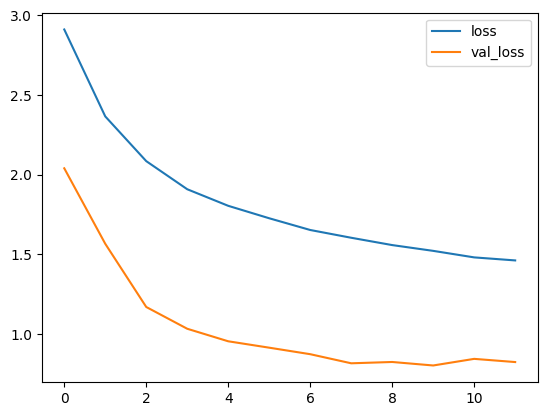

203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test set accuracy: 76%


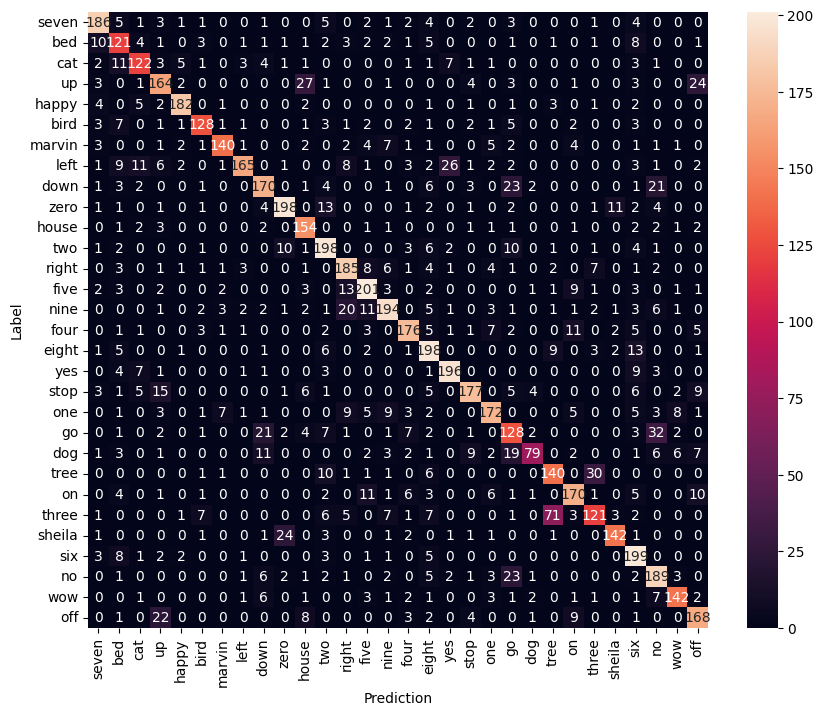

In [20]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

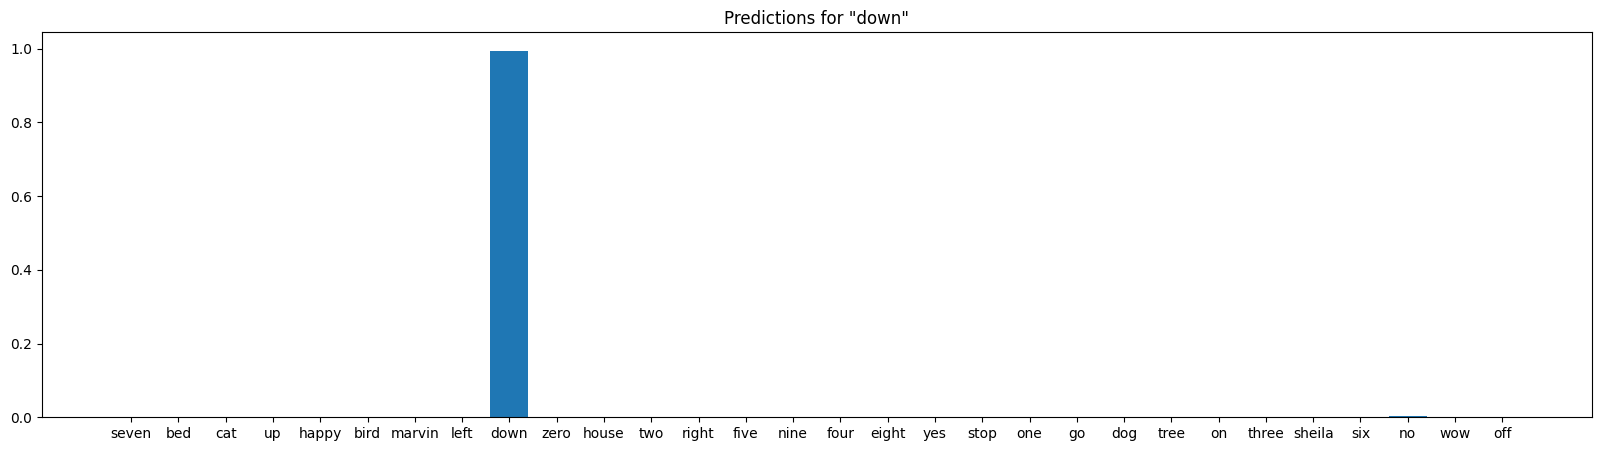

In [21]:
sample_file = "/kaggle/working/extracted_data/train/audio/down/0a9f9af7_nohash_0.wav"
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.figure(figsize=(20, 5))
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()

In [48]:
submission_sample = pd.read_csv("/kaggle/working/sample_submission.csv")
submission_sample

,fname,label
0,clip_000044442.wav,silence
1,clip_0000adecb.wav,silence
2,clip_0000d4322.wav,silence
3,clip_0000fb6fe.wav,silence
4,clip_0001d1559.wav,silence
...,...,...
158533,clip_fffe49419.wav,silence
158534,clip_ffff2fb36.wav,silence
158535,clip_ffff90f56.wav,silence
158536,clip_ffff98589.wav,silence


In [65]:
# Data and extraction directories
data_dir = "/kaggle/input/tensorflow-speech-recognition-challenge/"
extract_dir = '/kaggle/working/extracted_data_test/'

# Extract the data if it hasn't been already
if not os.path.exists(extract_dir):
    filepath = os.path.join(data_dir, "test.7z")
    print(f"Extracting files from {filepath} to {extract_dir}...")
    extract_7z(filepath, extract_dir)
else:
    print(f"Data already extracted at {extract_dir}")

Data already extracted at /kaggle/working/extracted_data_test/


In [66]:
filepath_data = "/kaggle/working/extracted_data_test/test/audio/"
filenames = os.listdir(filepath_data)
filenames_path = [filepath_data + i for i in filenames]

In [67]:
test_ds = preprocess_dataset(filenames_path)
test_ds = test_ds.batch(1)

labels = []

for spectrogram in tqdm(test_ds):
    spectrogram = spectrogram[0]
    prediction = model(spectrogram)
    
    probabilities = tf.nn.softmax(prediction[0])
    predicted_index = tf.argmax(probabilities).numpy()
    predicted_command = commands[predicted_index]
    
    labels.append(predicted_command)

#     print(f"Probabilities: {probabilities.numpy()}")
#     print(f"Predicted Command: {predicted_command}")

100%|██████████| 158538/158538 [43:44<00:00, 60.40it/s]


In [69]:
submission = pd.DataFrame({"fnane":filenames,"label":labels})
submission.to_csv("submission.csv", index=False)
submission

,fnane,label
0,clip_57dd43d43.wav,yes
1,clip_e0f6a0d2e.wav,three
2,clip_e8828ede6.wav,seven
3,clip_9b019155a.wav,go
4,clip_552ab0b62.wav,one
...,...,...
158533,clip_eb0c03d89.wav,go
158534,clip_69998f177.wav,bird
158535,clip_d9e07b66d.wav,on
158536,clip_67898681c.wav,five


_________________________________
## Conclusion 
This project demonstrates the application of deep learning techniques for speech command recognition. By leveraging 
CNNs torteature extraction and GRUS for sequence modeling, the system achieves a high level of accuracy in classitying 
spoken commands. The project highlights the importance of data preprocessing, augmentation, and model architecture in 
building effective speech recognition systems. Future improvements could include experimenting With ditterent model 
architectures, optimizing hyperparameters, and expanding the dataset tor better generalization. 
Feel free to adjust this description to better tit your portfolio! If you need any more details or modifications, just let me know. 